# QSoverlay tutorial

## What is QSoverlay

- A bunch of helper functions to make quantumsim slightly easier to use.
- Takes care of timing, experimental noise, and gate decomposition.
- Directly imports qasm.
- Allows importing and saving of experimental setup data and circuits.
- To be eventually incorporated in quantumsim (separate to prevent interference).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Basic use of QSoverlay

### Setup files

QSoverlay's first tool is the setup file. This contains the list of allowed gates for the experiment, and details about the error model for each such gate.

Note that 'allowed gates' includes gates that are decomposed under the hood into the actual gates that are performed in an experiment (e.g. CNOT).

Currently, the easiest way to generate a setup file is to use a 'quick_setup' function, which uses standard parameters (i.e. those from arXiv:1703.04136, but with incoherent 2-qubit dephasing) that may be adjusted when the function is called.

In [2]:
from qsoverlay.DiCarlo_setup import quick_setup

# We need a random number generator here - to prevent multiple seeding
# it is by far preferable to make a single numpy.random.RandomState
# with our favourite seed here and reuse it throughout the notebook.
# It is also possible to pass seeds to qsoverlay and let it deal
# with the random number generation itself, but then you must be
# very careful to prevent re-using the same seed multiple times.
random_state = np.random.RandomState(seed=42)  # chosen by Douglas Adams, guaranteed to be random

# Lets set the t1 differently (25us instead of 30us)
t1 = 25000
# We need to define which qubits we have
qubit_list = ['q1', 'q2']
connectivity_dic = {'q1': ['q2'], 'q2':['q1']}
setup = quick_setup(qubit_list=qubit_list, t1=t1, connectivity_dic=connectivity_dic, state=random_state)

There are two other parameters available to quick_setup: the 'noise_flag' parameter, which turns off noise entirely when set to false, and the 'scale' parameter, which multiplies all error rates and divides T1 and T2 (making it a first order approximation to the statement 'make qubits X% better/worse')

Currently making a setup file isn't the easiest thing to do (improving this is high on the TODO list). But, setup files can be stored and loaded as json files.

In [4]:
from qsoverlay import Setup  # The root class returned by quick_setup
setup.save(filename='test_setup.json')
# The state must be re-passed to the Setup upon loading
new_setup = Setup(filename='test_setup.json', state=random_state)

### The builder
The builder is the bit of qsoverlay that makes quantumsim circuits from a theoretical description using the setup file.

In [5]:
from qsoverlay import Builder
b = Builder(new_setup)

Let's use this to make a 2-qubit VQE circuit.

When we make this circuit, we want to leave some of our gates with adjustable free parameters. To do this, we flag them in the builder to be returned.

(<Figure size 792x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a8c1a3cc0>)

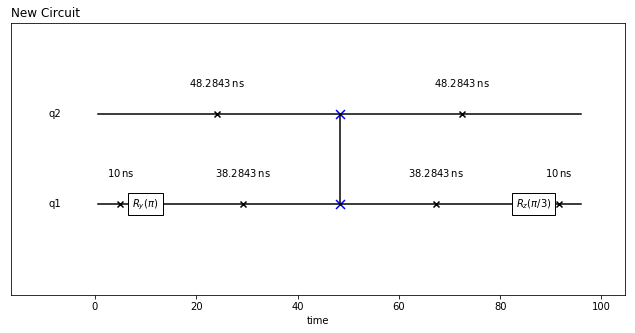

In [6]:
adjustable_gates = []
b.add_gate('Ry',['q1'],angle=np.pi)  # This angle is fixed

# As we will adjust the angle later, fix it to whatever we want now.
adjustable_gates.append(
    b.add_gate('ISwapRotation', ['q1','q2'], angle=np.pi/6, return_flag=1))

# There is another format you can use to add gates, which is a bit shorter
adjustable_gates.append(('Rz', 'q1', np.pi/3, 1) > b)

b.finalize()
plt.figure(figsize=(11,5))
b.circuit.plot()

### How to time gates
The builder keeps a 'time' for each qubit (starting at 0), and increments this by the time taken for every gate that is added. The gate in turn is initialized with knowledge of this time, as well as any parameters that we know it needs (e.g. dephasing probabilities, readout infidelity, etc).

As well as generating all this, the builder also stores a list of instructions that can be saved or used to reconstruct the circuit.

Number of new adjustable gates:  2


(<Figure size 792x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a89eaaeb8>)

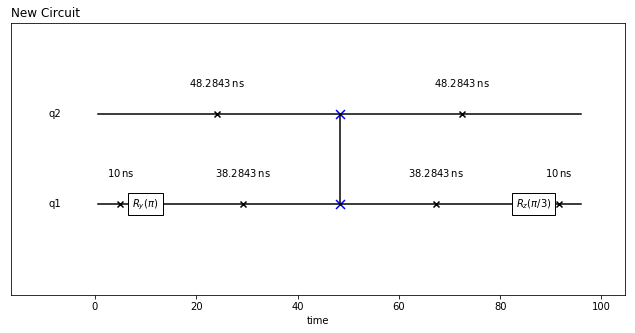

In [7]:
b2 = Builder(new_setup)
adjustable_gates2 = b2.add_circuit_list(b.circuit_list)
print('Number of new adjustable gates: ',len(adjustable_gates2))
b2.finalize()
plt.figure(figsize=(11,5))
b2.circuit.plot()

The builder also accepts two standard forms of qasm - either in the form:
- gate_name qubit1 \[qubit2 ...\] param1 \[param2 ...\] (default)
- gate_name param1 \[param2 ...\] qubit1 \[qubit2 ...\] (set qubits_first=False)

Note though that this doesn't support returning the adjustable gates as described above

(<Figure size 792x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a89c58978>)

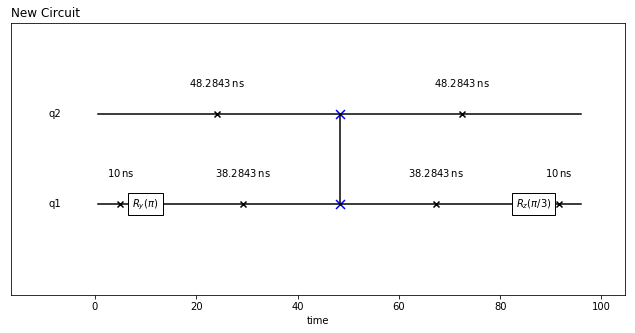

In [8]:
qasm_list = [
    'Ry q1 ' + str(np.pi),
    'ISwapRotation q1 q2 ' + str(np.pi/6),
    'Rz q1 ' + str(np.pi/3),
]
b2.new_circuit()  # You can reset the builder instead of making a new one
b2.add_qasm(qasm_list)
b2.finalize()
plt.figure(figsize=(11,5))
b2.circuit.plot()

The builder also has the ability to decompose gates into their underlying primitives for the experimental setup. The amount of gates this works for is extremely limited though, but we can try to make a Bell state via a Hadamard + CNOT

(<Figure size 792x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a89ae13c8>)

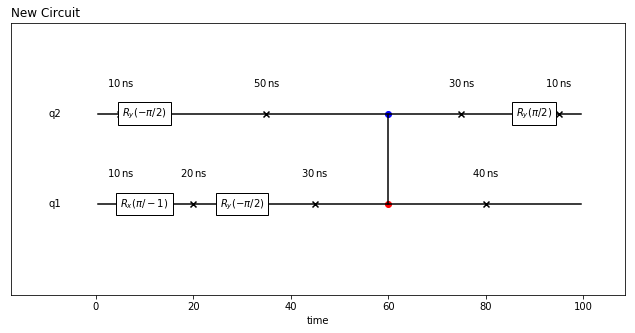

In [9]:
qasm_list = [
    'Had q1',
    'CNOT q1 q2',
]
b2.new_circuit()  # You can reset the builder instead of making a new one
b2.add_qasm(qasm_list)
b2.finalize()
plt.figure(figsize=(11,5))
b2.circuit.plot()

### The experiment controller
Beyond making circuits, qsoverlay also gives a container to hold and save multiple circuits, make states, apply circuits to states, and do limited tomography on states.

In [12]:
from qsoverlay import Controller

# We store the details of multiple circuits in dictionaries,
# right now we have only one.
circuits = {'VQE': b.circuit}
circuit_lists = {'VQE': b.circuit_list}  # This is only needed for saving
adjust_gates = {'VQE': adjustable_gates}  # Not every circuit needs to be here.

# If we are doing measurements, we should also write the list
# of bits that receive measurement output.
mbits = []

# One additional thing we have the option of doing:
# If we want one parameter to control the angle of multiple gates,
# this can be controlled via an 'angle_convert_matrix'.
angle_convert_matrices = {}

c = Controller(qubits=qubit_list,
               setup=setup,  # Only needed for saving
               circuits=circuits,
               circuit_lists=circuit_lists,
               mbits=mbits,
               angle_convert_matrices=angle_convert_matrices,
               adjust_gates=adjust_gates,
               random_state=random_state)

Controllers can be saved and loaded

In [14]:
c.save('test_controller.json')

# The controller recreates circuits using a setup file,
# allowing for the same experiment to be run with multiple setups.
c2 = Controller(filename='test_controller.json',
                setup='test_setup.json',
                random_state=random_state)

ValueError: 
                We require either a numpy.random.RandomState
                or a non-null seed for a setup.

It's pretty simple to run a VQE experiment with a controller

In [11]:
# The measurements we need to take for QPE
msmts = [
    {'q1': 'Z', 'q2': 'Z'},
    {'q1': 'X', 'q2': 'X'},
    {'q1': 'Y', 'q2': 'Y'},
    {'q1': 'Z'},
    {'q2': 'Z'}
]

def VQE_experiment(*angles):
    c2.make_state()
    ('VQE', *angles) > c2  # Runs the circuit with angles fixed to pi/2
    return c2.get_expectation_values(msmts, num_repetitions=None)

print(VQE_experiment(0,0).round(2))
print(VQE_experiment(np.pi/2,np.pi/2).round(2))

[-0.99  0.    0.   -0.99  1.  ]
[-0.99  0.    0.    1.   -0.99]


In [12]:
# Lets try minimizing this on some system
h_vec = np.array([1.9, 0.5, 0.3, 0.6, 0.6])
def VQE_minimization(angles):
    m_vec = VQE_experiment(*angles)
    return np.dot(h_vec, m_vec)

from scipy.optimize import minimize
res = minimize(VQE_minimization, x0=[np.pi/2,np.pi/2])

# See how well we did
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
s0 = np.array([[1,0],[0,1]])
ham = h_vec[0] * np.kron(sz,sz) +\
    h_vec[1] * np.kron(sx,sx) +\
    h_vec[2] * np.kron(sy,sy) +\
    h_vec[3] * np.kron(sz,s0) +\
    h_vec[4] * np.kron(s0,sz)

evs = np.linalg.eigvalsh(ham)

print('VQE minimum = ',res['fun'], ' True ev = ', min(evs))

VQE minimum =  -2.6738846480360956  True ev =  -2.7


# Direct measurement - todo: finish section
Now let's try the above again, but without doing direct tomography

(<Figure size 2160x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa4b9f2438>)

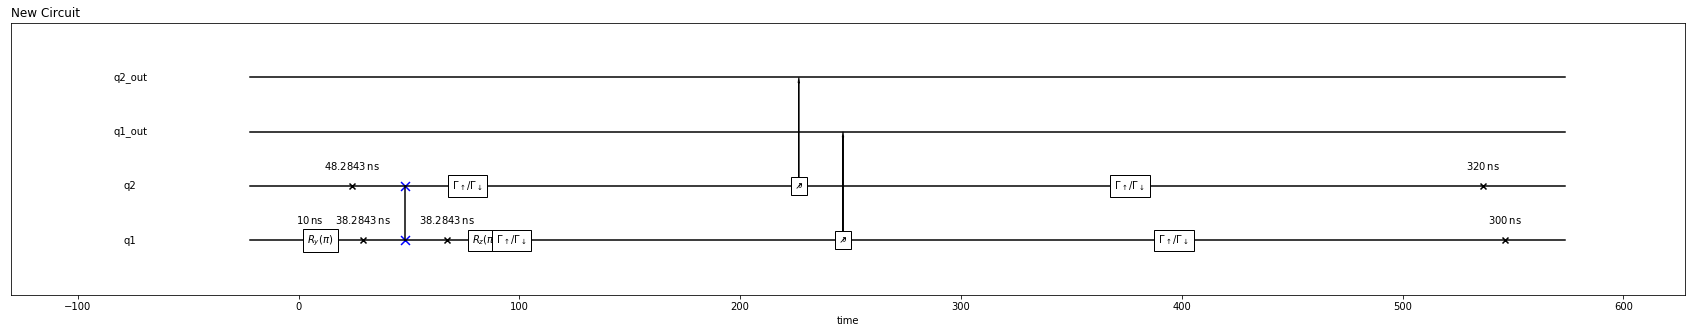

In [13]:
b2.new_circuit()  # You can reset the builder instead of making a new one
adjustable_gates = []

b2.add_gate('Ry',['q1'],angle=np.pi)  # This angle is fixed

# As we will adjust the angle later, fix it to whatever we want now.
adjustable_gates.append(
    b2.add_gate('ISwapRotation', ['q1','q2'], angle=np.pi/6, return_flag=1))

# There is another format you can use to add gates, which is a bit shorter
adjustable_gates.append(('Rz', 'q1', np.pi/3, 1) > b2)

mg1 = b2.add_gate('Measure', ['q1'], output_bit = 'q1_out', return_flag=2)
mg2 = b2.add_gate('Measure', ['q2'], output_bit = 'q2_out', return_flag=2)
b2.finalize()
plt.figure(figsize=(30,5))
b2.circuit.plot()

Apologies for the mess - the measurement gate is rather complicated, as it consists of a decay event before an instantaneous readout, and a decay gate afterwards. The readout itself can also have noise - this is either set by readout_error, or by a fancy choice of sampler in quantumsim (this is rather under the hood, let's not go into it here). You can also see that measurement is rather long compared to single and two-qubit gates, ce la vie for superconducting qubits.

In [14]:
# We store the details of multiple circuits in dictionaries,
# right now we have only one.
circuits = {'VQE': b2.circuit}
circuit_lists = {'VQE': b2.circuit_list}  # This is only needed for saving
adjust_gates = {'VQE': adjustable_gates}  # Not every circuit needs to be here.
measurement_gates = {'VQE': [mg1, mg2]}

# If we are doing measurements, we should also write the list
# of bits that receive measurement output.
mbits = ['q1_out', 'q2_out']

# One additional thing we have the option of doing:
# If we want one parameter to control the angle of multiple gates,
# this can be controlled via an 'angle_convert_matrix'.
angle_convert_matrices = {}

c = Controller(qubits=qubit_list,
               setup=setup,  # Only needed for saving
               circuits=circuits,
               circuit_lists=circuit_lists,
               mbits=mbits,
               angle_convert_matrices=angle_convert_matrices,
               adjust_gates=adjust_gates,
               measurement_gates=measurement_gates)

In [15]:
c.make_state
print(c.apply_circuit('VQE'))

[{'probabilities': [0.2483511771667531, 1.1605384476773374e-16], 'projects': 0, 'measurements': 0}, {'probabilities': [0.7516488228332487, 0.24835117716675295], 'projects': 1, 'measurements': 1}]


## Future plans and todo

- Integrate with quantumsim.
- Make toolbox to create setup files (ideally so that an experimentalist can make a setup file to give to a theorist with minimal effort).
- Measurement and conditional gates currently very hacked together - needs fix (probably within the circuit module, as the RNG for a sampler needs to be made circuit-wide instead of gate-wide).
- Currently no routines to compile single qubit gates, teleport two-qubit gates etc
- Currently not scheduling qubits around 2-qubit gates properly (i.e. noting which qubits are away from their sweet-spot, etc).
- Currently no good way of setting 2-qubit gate parameters independently (drawn from qubit error parameters).

## Questions for the audience

- Are there any other formats I should take for circuit input?
- The controller save file seems like a good way of linking this to experiment, how can we best incorporate this?
- How can I best approximate noisy tomography?